##  Load libraries

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import tensorflow as tf

from skimage import io
from tensorflow import keras
from tensorflow.keras import layers


## Parameters

In [21]:
latent_dim    = 128

scale         = 0.5
epochs        = 10
batch_size    = 32
num_img       = 12
fit_verbosity = 1

run_dir = './run/SHEEP1.001'

## Dataset

In [5]:
x_data = np.load('sheep.npy')
print('Original dataset shape : ',x_data.shape)

Original dataset shape :  (126121, 784)


In [6]:
# Rescale
n=int(scale*len(x_data))
x_data = x_data[:n]
print('Rescaled dataset shape : ',x_data.shape)

Rescaled dataset shape :  (63060, 784)


In [7]:
# Normalize, reshape and shuffle
x_data = x_data/255
x_data = x_data.reshape(-1,28,28,1)
np.random.shuffle(x_data)
print('Final dataset shape    : ',x_data.shape)


Final dataset shape    :  (63060, 28, 28, 1)


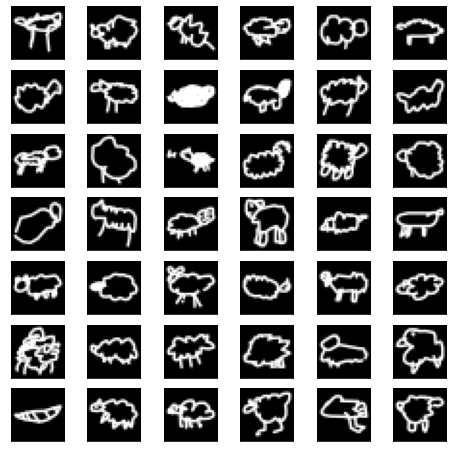

In [8]:
fig = plt.figure(figsize=(8, 8)) 
columns = 6 
rows = 7 
for i in range(1,columns*rows+1): 
    fig.add_subplot(rows, columns, i) 
    plt.yticks([])
    plt.xticks([])
    plt.imshow(x_data[i-1], cmap='gray') 
plt.show()

In [1]:
## Build a Gan model

In [9]:
# Discriminator

inputs  = keras.Input(shape=(28, 28, 1))
x       = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
x       = layers.LeakyReLU(alpha=0.2)(x)
x       = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x       = layers.LeakyReLU(alpha=0.2)(x)
x       = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x       = layers.LeakyReLU(alpha=0.2)(x)
x       = layers.Flatten()(x)
x       = layers.Dropout(0.2)(x)
z       = layers.Dense(1, activation="sigmoid")(x)

discriminator = keras.Model(inputs, z, name="discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)       

2022-08-16 11:55:18.241911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-16 11:55:18.684774: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-16 11:55:18.684813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4253 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


In [10]:
# Generator

inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64)(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.UpSampling2D()(x)
x       = layers.Conv2D(128,  kernel_size=3, strides=1, padding='same', activation='relu')(x)
x       = layers.UpSampling2D()(x)
x       = layers.Conv2D(256,  kernel_size=3, strides=1, padding='same', activation='relu')(x)
outputs = layers.Conv2D(1,    kernel_size=5, strides=1, padding="same", activation="sigmoid")(x)

generator = keras.Model(inputs, outputs, name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              404544    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 128)      0         
 2D)                                                     

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display,Markdown
import os

class DCGAN(keras.Model):
    '''
    A DCGAN model, built from given generator and discriminator
    '''

    version = '1.0'



    def __init__(self, discriminator=None, generator=None, latent_dim=100, **kwargs):
        '''
        DCGAN instantiation with a given discriminator and generator
        args :
            discriminator : discriminator model
            generator : generator model
            latent_dim : latent space dimension
        return:
            None
        '''
        super(DCGAN, self).__init__(**kwargs)
        self.discriminator = discriminator
        self.generator     = generator
        self.latent_dim    = latent_dim
        print(f'Fidle DCGAN is ready :-)  latent dim = {latent_dim}')


        
    def call(self, inputs):
        '''
        Implementation of the model forward pass
        args:
            inputs : vectors from latent space
        return:
            output : Output of the generator
        '''
        outputs = self.generator(inputs)
        return outputs
                


    def compile(self, 
                discriminator_optimizer = keras.optimizers.Adam(), 
                generator_optimizer     = keras.optimizers.Adam(), 
                loss_function           = keras.losses.BinaryCrossentropy() ):
        '''
        Compile the model
        args:
            discriminator_optimizer : Discriminator optimizer (Adam)
            generator_optimizer : Generator optimizer (Adam)
            loss_function : Loss function
        '''
        super(DCGAN, self).compile()
        self.discriminator.compile(optimizer=discriminator_optimizer, loss=loss_function)
        self.generator.compile(optimizer=generator_optimizer, loss=loss_function)
        
        self.d_optimizer   = discriminator_optimizer
        self.g_optimizer   = generator_optimizer
        self.loss_fn       = loss_function
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")



    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]



    def train_step(self, inputs):
        '''
        Implementation of the training update.
        Receive some real images.
        This will compute loss, get gradients and update weights for generator and discriminator
        Return metrics.
        args:
            real_images : real images
        return:
            d_loss  : discriminator loss
            g_loss  : generator loss
        '''

        # ---- Prepare data for discriminator ----------------------
        # ----------------------------------------------------------
        #        
        # ---- Get the input we need, specified in the .fit()
        #      inputs is a tuple of tensors
        #
        if isinstance(inputs, tuple):
            real_images = inputs[0]
        else:
            real_images = inputs

        batch_size=tf.shape(real_images)[0]

        # Get some random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images with the generator
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat( [generated_images, real_images], axis=0)

        # Creation of labels corresponding to real or fake images
        # 0 is generated, 1 is real
        labels = tf.concat( [tf.zeros((batch_size, 1)),  tf.ones((batch_size, 1))], axis=0)

        # Add random noise to the labels - important trick !
#         labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # ---- Train the discriminator -----------------------------
        # ----------------------------------------------------------
        #
        # ---- Forward pass
        #      Run the forward pass and record operations with the GradientTape.
        #
        with tf.GradientTape() as tape:

            # Get predictions from discriminator 
            predictions = self.discriminator(combined_images)

            # Get loss
            d_loss = self.loss_fn(labels, predictions)

        # ---- Backward pass
        #      Retrieve gradients from gradient_tape and run one step
        #      of gradient descent to optimize trainable weights
        #
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients( zip(grads, self.discriminator.trainable_weights) )

        # ---- Prepare data for generator ----------------------
        # ----------------------------------------------------------
        #
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say all images are real, yes it's a lie ;-)
        misleading_labels = tf.ones((batch_size, 1))

        # ---- Train the generator ---------------------------------
        # ----------------------------------------------------------
        # We should *not* update the weights of the discriminator!
        # We will train our generator so that the generated images 
        # are considered as real by the discriminator
        #
        # ---- Forward pass
        #      Run the forward pass and record operations with the GradientTape.
        #
        with tf.GradientTape() as tape:

            # Get fake images from generator
            fake_images = self.generator(random_latent_vectors)

            # Get predictions from discriminator 
            predictions = self.discriminator(fake_images)

            # Get loss
            g_loss = self.loss_fn(misleading_labels, predictions)
        
        # ---- Backward pass (only for generator)
        #      Retrieve gradients from gradient_tape and run one step
        #      of gradient descent to optimize trainable weights
        #
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # ---- Update and return metrics ---------------------------
        # ----------------------------------------------------------
        #
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

            
    def save(self,filename):
        '''Save model in 2 part'''
        save_dir             = os.path.dirname(filename)
        filename, _extension = os.path.splitext(filename)
        # ---- Create directory if needed
        os.makedirs(save_dir, mode=0o750, exist_ok=True)
        # ---- Save models
        self.discriminator.save( f'{filename}-discriminator.h5' )
        self.generator.save(     f'{filename}-generator.h5'     )

    
    def reload(self,filename):
        '''Reload a 2 part saved model.
        Note : to train it, you need to .compile() it...'''
        filename, extension = os.path.splitext(filename)
        self.discriminator = keras.models.load_model(f'{filename}-discriminator.h5', compile=False)
        self.generator     = keras.models.load_model(f'{filename}-generator.h5'    , compile=False)
        print('Reloaded.')

In [16]:
gan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    generator_optimizer     = keras.optimizers.Adam(learning_rate=0.0001),
    loss_function           = keras.losses.BinaryCrossentropy(),
)

Fidle DCGAN is ready :-)  latent dim = 128


In [17]:
class ImagesCallback(keras.callbacks.Callback):

    def __init__(self, 
                 num_img    = 3, 
                 latent_dim = 100,
                 filename   = 'image-{epoch:03d}-{i:02d}.jpg',
                 run_dir    = './run'):
        self.num_img    = num_img
        self.latent_dim = latent_dim
        self.filename   = filename
        self.run_dir    = run_dir
        os.makedirs(run_dir, mode=0o750, exist_ok=True)


    def save_images(self, images, epoch):
        '''Save images as <filename>'''
        
        for i,image in enumerate(images):
            
            image = image.squeeze()  # Squeeze it if monochrome : (lx,ly,1) -> (lx,ly) 
        
            filenamei = self.run_dir+'/'+self.filename.format(epoch=epoch,i=i)
            
            if len(image.shape) == 2:
                plt.imsave(filenamei, image, cmap='gray_r')
            else:
                plt.imsave(filenamei, image)



    def on_epoch_end(self, epoch, logs=None):

        # ---- Get some points from latent space
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))

        # ---- Get fake images from generator
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = np.array(generated_images)

        # ---- Save them
        self.save_images(generated_images, epoch)


In [22]:
imagesCallback = ImagesCallback(num_img=num_img, latent_dim=latent_dim, run_dir=f'{run_dir}/images')

history = gan.fit( x_data, 
                   epochs=epochs, 
                   batch_size=batch_size, 
                   callbacks=[imagesCallback], 
                   verbose=fit_verbosity )


gan.save(f'{run_dir}/models/model.h5')


Epoch 1/10


2022-08-16 12:02:16.102478: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-16 12:02:16.582413: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1971/1971 [==============================] - 30s 14ms/step - d_loss: 0.4331 - g_loss: 1.6258
Epoch 2/10
1971/1971 [==============================] - 27s 14ms/step - d_loss: 0.5642 - g_loss: 1.0676
Epoch 3/10
1971/1971 [==============================] - 27s 14ms/step - d_loss: 0.5399 - g_loss: 1.1422
Epoch 4/10
1971/1971 [==============================] - 27s 14ms/step - d_loss: 0.4984 - g_loss: 1.2253
Epoch 5/10
1971/1971 [==============================] - 27s 14ms/step - d_loss: 0.5155 - g_loss: 1.1931
Epoch 6/10
1971/1971 [==============================] - 27s 14ms/step - d_loss: 0.5538 - g_loss: 1.1003
Epoch 7/10
1971/1971 [==============================] - 27s 14ms/step - d_loss: 0.5694 - g_loss: 1.0508
Epoch 8/10
1971/1971 [==============================] - 27s 14ms/step - d_loss: 0.5799 - g_loss: 1.0237
Epoch 9/10
1971/1971 [==============================] - 27s 14ms/step - d_loss: 0.5826 - g_loss: 1.0255
Epoch 10/10
1971/1971 [==============================] - 27s 14ms/step - d_

## Result 

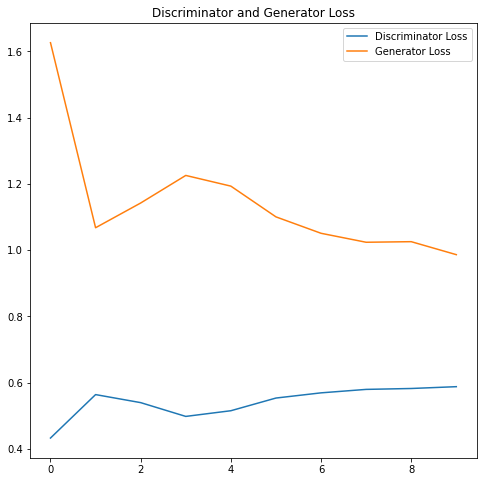

In [23]:

discriminator_loss = history.history['d_loss']
generator_loss = history.history['g_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.plot(epochs_range, discriminator_loss, label='Discriminator Loss')
plt.plot(epochs_range, generator_loss, label='Generator Loss')
plt.legend(loc='upper right')
plt.title('Discriminator and Generator Loss')
plt.show()

In [32]:
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos', save_as='auto'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
#         img=axs.imshow(xx,   cmap = cm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    plt.show()

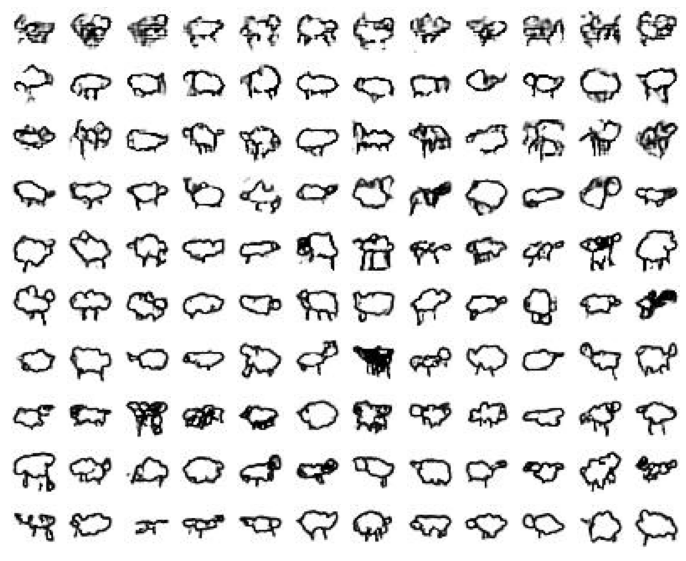

In [33]:
images=[]
for epoch in range(0,epochs,1):
    for i in range(num_img):
        filename = f'{run_dir}/images/image-{epoch:03d}-{i:02d}.jpg'
        image    = io.imread(filename)
        images.append(image)  

plot_images(images, None, indices='all', columns=num_img, x_size=1,y_size=1, interpolation=None, y_padding=0, spines_alpha=0)

In [34]:
gan.reload(f'{run_dir}/models/model.h5')

Reloaded.


In [35]:
nb_images = 12*15

z = np.random.normal(size=(nb_images,latent_dim))
images = gan.predict(z)


6/6 [==============================] - 0s 3ms/step


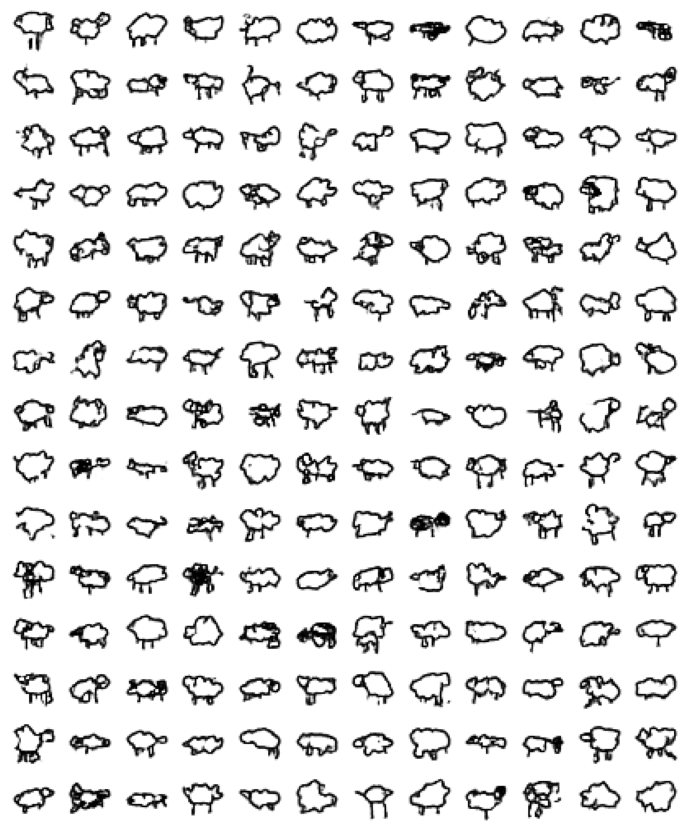

In [36]:
plot_images(images, None, indices='all', columns=num_img, x_size=1,y_size=1, interpolation=None, y_padding=0, spines_alpha=0, save_as='04-learning')